In [1]:
# default_exp preprocessing_pipeline

# Applying optimal preprocessing pipeline to Low samples

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path
import uuid
import re
import scipy

from ehv import load as e_load, core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [4]:
# export
from ehv import correlation, preprocessing_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import FastICA, PCA, KernelPCA
from umap import UMAP
from multiprocessing import Pool, cpu_count

In [5]:
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    None, "**/Low/*.cif")
df = e_load.clean_column_names(df)
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)

df = df[df["meta_label_coi"]]

reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

df = df.reset_index(drop=True)

## Setting up preprocessing pipelines

Steps:
1. Correlation
1. Scaling
1. Dimensionality reduction

In [6]:
# export
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import TransformerMixin, BaseEstimator, clone

In [7]:
# export
class GroupedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, base_transformer, group_key, n_jobs=-1):
        self.base_transformer = base_transformer
        self.group_key = group_key
        self.n_jobs = n_jobs if n_jobs >= 1 else cpu_count()
        
    def fit(self, df):
        self.transformers = {}
        with Pool(processes=self.n_jobs) as pool:
            for idx, gdf in df.groupby(self.group_key):
                self.transformers[idx] = pool.apply_async(clone(self.base_transformer).fit, args=(gdf.drop(columns=self.group_key),))
            for k,v in self.transformers.items():
                self.transformers[k] = v.get()
        return self
            
    def transform(self, df):
        columns = df.drop(columns=self.group_key).columns
        dfs = []
        with Pool(processes=self.n_jobs) as pool:
            promises = []
            for idx, gdf in df.groupby(self.group_key):
                promises.append(pool.apply_async(self.transformers[idx].transform, args=(gdf[columns],)))
            for (promise, (idx, gdf)) in zip(promises, df.groupby(self.group_key)):
                gdf[columns] = promise.get()
                dfs.append(gdf)
        return pandas.concat(dfs)
    
class ColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, col_selector, append=False, drop_remainder=False):
        self.transformer = transformer
        self.col_selector = col_selector
        self.append = append
        self.drop_remainder = drop_remainder
        
    def fit(self, df, y=None):
        self.transformer.fit(df[self.col_selector(df)])
        return self
    
    def transform(self, df, y=None):
        
        data = self.transformer.transform(df[self.col_selector(df)])
        if hasattr(data, "iloc"):
            tmp_df = data
        else:
            if len(self.col_selector(df)) == data.shape[1]:
                columns = self.col_selector(df)
            else:
                columns = ["feat_%s_%s" % (self.transformer.__class__.__name__.lower(), i) for i in range(data.shape[1])]
                
            tmp_df = pandas.DataFrame(
                data = data,
                columns = columns,
                index = df.index
            )
                
        if self.append:
            return pandas.concat([df, tmp_df], axis=1)
        elif self.drop_remainder:
            return pandas.concat([df.drop(columns=self.col_selector(df)), tmp_df], axis=1)
        else:
            df = df.copy()
            df[self.col_selector(df)] = tmp_df
            return df
        
    
class PandasVarianceThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=0.0):
        self.thresh = thresh
        self.var = VarianceThreshold()
        
    def fit(self, X):
        self.var.fit(X)
        return self
    
    def transform(self, X):
        return X[X.columns[self.var.get_support()]]

In [8]:
feat_selector = make_column_selector(pattern="feat")
meta_selector = make_column_selector(pattern="^(feat|meta_timepoint).*")

## Normalize + Power transform

In [14]:
%%time
pipe = preprocessing_pipeline.make_pipeline_1()

# Feedback needed from Flora about ch2 and ch3
res = pipe.fit_transform(df.drop(columns=df.filter(regex="(m|ch)0?(2|3)")))

CPU times: user 20min 46s, sys: 3min 7s, total: 23min 53s
Wall time: 5min 18s


In [31]:
u = uuid.uuid4()

In [18]:
res.reset_index()

,index,meta_system_object_number,meta_system_time,meta_system_flow_speed,meta_timepoint,meta_replicate,meta_group,meta_label_coi,meta_label_mcp_neg_psba_pos,meta_label_mcp_pos_psba_pos,...,feat_pca_11,feat_pca_12,feat_pca_13,feat_pca_14,feat_pca_15,feat_pca_16,feat_pca_17,feat_pca_18,feat_umap_0,feat_umap_1
0,0,2,0.329456,43.341599,3,R2,Low,True,True,False,...,-0.252157,0.276872,-0.206182,0.117673,-0.116699,-0.220331,-0.461343,0.274318,13.343157,-2.199019
1,1,3,0.349171,43.341599,3,R2,Low,True,True,False,...,-1.176131,0.779775,-0.686375,-0.007268,-0.665866,-0.743744,-0.199143,0.115398,10.382875,-3.617225
2,2,4,0.373577,43.317261,3,R2,Low,True,True,False,...,-0.538765,0.476027,0.791493,0.797693,0.567921,1.193735,-0.120974,-0.079626,10.241647,0.814337
3,3,6,0.101911,43.317261,3,R2,Low,True,True,False,...,-0.580364,-0.105036,-0.916202,0.984669,-0.498309,0.993779,0.790471,0.132211,11.024343,2.529662
4,4,7,0.102583,43.317261,3,R2,Low,True,True,False,...,-0.717061,-0.343284,0.659228,-0.113903,0.253547,-0.509148,-0.057236,-0.400985,13.823543,-2.072700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339040,339040,19985,105.284981,43.365959,7,R3,Low,True,True,False,...,-1.430545,-0.951689,-1.105325,-1.513429,-1.175054,0.141434,-0.719806,0.179784,10.527164,4.561990
339041,339041,19987,105.290154,43.341599,7,R3,Low,True,True,False,...,1.034451,0.169102,0.285126,1.025931,-0.127385,-0.038779,-0.908127,0.132869,15.144169,-0.382416
339042,339042,19989,105.292427,43.341599,7,R3,Low,True,True,False,...,1.174983,-1.421291,0.098630,3.165950,0.361362,0.578308,0.192386,-0.143012,14.617172,1.221040
339043,339043,19990,105.294601,43.341599,7,R3,Low,True,False,True,...,1.125335,0.294959,0.123997,-0.020652,-0.241208,-0.364594,-0.407703,0.474269,-4.053893,-0.284710


In [9]:
res = pandas.read_feather("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/563611cc-3e47-435a-b856-4e39dd73f556.feather")

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

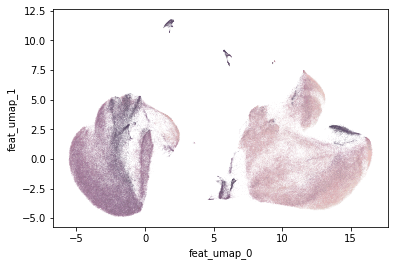

In [13]:
seaborn.scatterplot(data=res, x="feat_umap_0", y="feat_umap_1", hue="meta_timepoint", s=0.1, alpha=0.5, edgecolors='none', legend=False)
# plt.savefig("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/assets/thumbs/%s.jpg" % u)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

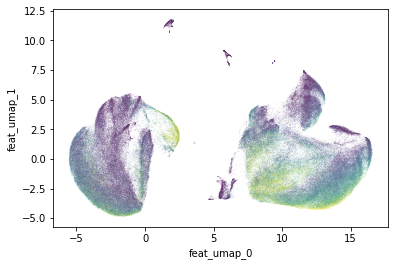

In [14]:
feat = "feat_cont_bright_detail_intensity_r3_mc_ch11"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=res, x="feat_umap_0", y="feat_umap_1", c=df[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

In [15]:
res.filter(regex="feat").corr()["feat_umap_0"].abs().sort_values(ascending=False)[:20]

feat_umap_0                                     1.000000
feat_cont_aspect_ratio_m04                      0.904805
feat_cont_aspect_ratio_intensity_m04_ch04       0.877717
feat_cont_width_m04                             0.877559
feat_cont_gradient_rms_m04_ch04                 0.872700
feat_cont_height_m04                            0.833960
feat_cont_length_m04                            0.832792
feat_cont_mean_pixel_m04_ch04                   0.772259
feat_cont_area_m04                              0.764894
feat_cont_median_pixel_m04_ch04                 0.756736
feat_cont_max_pixel_mc_ch04                     0.750691
feat_cont_mean_pixel_m09_bf2                    0.702562
feat_pca_0                                      0.691152
feat_pca_1                                      0.660865
feat_cont_max_pixel_mc_ch03                     0.655951
feat_cont_bright_detail_intensity_r3_mc_ch04    0.645585
feat_cont_intensity_mc_ch04                     0.636989
feat_cont_width_m03            

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

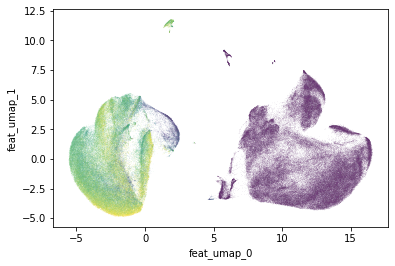

In [18]:
feat = "feat_cont_width_m04"
norm = matplotlib.colors.Normalize(vmin=res[feat].quantile(0.05), vmax=res[feat].quantile(0.95))
seaborn.scatterplot(data=res, x="feat_umap_0", y="feat_umap_1", c=res[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)

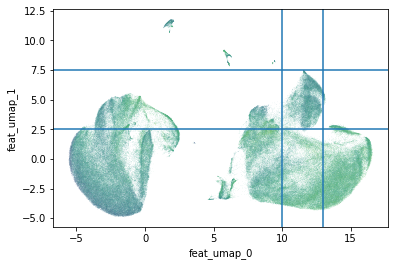

In [19]:
feat = "feat_cont_gradient_rms_m09_bf2"
norm = matplotlib.colors.Normalize(vmin=res[feat].quantile(0), vmax=res[feat].quantile(1))
ax = seaborn.scatterplot(data=res, x="feat_umap_0", y="feat_umap_1", c=res[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
ax.axvline(10)
ax.axvline(13)
ax.axhline(7.5)
ax.axhline(2.5)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

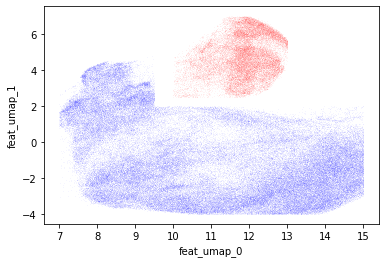

In [26]:
pop1 = res[
    (res["feat_umap_1"] < 7) & (res["feat_umap_1"] > 2.5) &
    (res["feat_umap_0"] < 13) & (res["feat_umap_0"] > 10)
].copy()
pop2 = res[
    ((res["feat_umap_1"] < 2) & (res["feat_umap_1"] > -4) &
    (res["feat_umap_0"] < 15) & (res["feat_umap_0"] > 7)) |
    ((res["feat_umap_1"] < 5) & (res["feat_umap_1"] > -4) &
    (res["feat_umap_0"] < 9.5) & (res["feat_umap_0"] > 7))
].copy()

ax = seaborn.scatterplot(data=pop1, x="feat_umap_0", y="feat_umap_1", color="red", s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
seaborn.scatterplot(data=pop2, x="feat_umap_0", y="feat_umap_1", color="blue", s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm, ax=ax)

In [27]:
diff = pop1.filter(regex="feat").median() - pop2.filter(regex="feat").median()

In [28]:
diff.sort_values(ascending=False)

feat_cont_intensity_mc_bf2                        577.930664
feat_cont_intensity_mc_ch04                       553.988525
feat_cont_bright_detail_intensity_r3_mc_ch04       46.000000
feat_cont_bright_detail_intensity_r3_mc_bf2        21.000000
feat_cont_area_m11                                  8.777779
                                                    ...     
feat_cont_intensity_mc_ssc                      -4064.823242
feat_cont_intensity_mc_ch11                     -7364.410156
feat_cont_bright_detail_intensity_r3_mc_ch11    -7572.000000
feat_cont_bright_detail_intensity_r3_mc_ch7     -8749.500000
feat_cont_intensity_mc_ch7                     -33901.968750
Length: 123, dtype: float32

In [29]:
pop1["pop"] = 1
pop2["pop"] = 2
pops = pandas.concat([pop1,pop2])

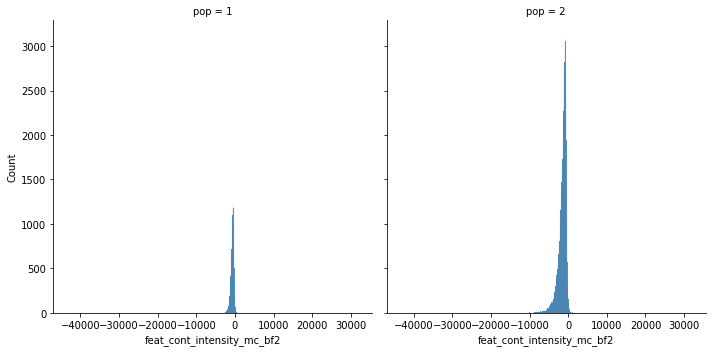

In [32]:
seaborn.displot(data=pops, x="feat_cont_intensity_mc_bf2", col="pop")

In [ ]:
uuid = uuid.uuid4()

In [62]:
uuid

UUID('563611cc-3e47-435a-b856-4e39dd73f556')

In [74]:
for col in df:
    res[col] = df[col]

In [75]:
res = res.reset_index()
for col in res:
    if(res[col].dtype == numpy.int64):
        res[col] = res[col].astype(numpy.int32)

res.to_feather("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/%s.feather" % uuid, compression="uncompressed")